In [64]:
import h2o
import psutil
from h2o.automl import H2OAutoML
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
import pandas as pd
import numpy as np
from h2o.estimators.random_forest import H2ORandomForestEstimator
import matplotlib.pyplot as plt

# 1 Initialize H2O

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

8


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/25/079nl8ps1d17m_b9mm9cwnhm0000gn/T/tmpp_c51ipx
  JVM stdout: /var/folders/25/079nl8ps1d17m_b9mm9cwnhm0000gn/T/tmpp_c51ipx/h2o_guruisi_started_from_python.out
  JVM stderr: /var/folders/25/079nl8ps1d17m_b9mm9cwnhm0000gn/T/tmpp_c51ipx/h2o_guruisi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.2
H2O cluster version age:    1 year, 3 months and 23 days !!!
H2O cluster name:           H2O_from_python_guruisi_r1jxcs
H2O cluster total nodes:    1
H2O cluster free memory:    7.111 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.4 final
--------------------------  ---------------------------------------------------

# 2 Data Preprocessing

In [167]:
# Insert an index column as 'Id' in order to slice the dataset for ICE plot
data_path = "../data/Churn_Train.csv"
df = pd.read_csv(data_path)
df['Id'] = df.index
df.to_csv("../data/Churn.csv", index = False)

In [305]:
# Read the dataset with 'Id' column in H2O
data_path = "../data/Churn.csv"
df = h2o.import_file(data_path)
df.shape

(6499, 22)

In [300]:
df.head(5)

CustomerID Gender Senior Citizen Partner Dependents Tenure Phone Service Multiple Lines Internet Service Online Security Online Backup Device Protection Tech Support Streaming TV Streaming Movies Contract Paperless Billing Payment Method Monthly Charges Total Charges Churn Id 
 
 
 7590-VHVEG Female 0 Yes No 1 No No phone service DSL No Yes No No No No Month-to-month Yes Electronic check 29.85 29.85 No 0 
 5575-GNVDE Male 0 No No 34 Yes No DSL Yes No Yes No No No One year No Mailed check 56.95 1889.5 No 1 
 3668-QPYBK Male 0 No No 2 Yes No DSL Yes Yes No No No No Month-to-month Yes Mailed check 53.85 108.15 Yes 2 
 7795-CFOCW Male 0 No No 45 No No phone service DSL Yes No Yes Yes No No One year No Bank transfer (automatic) 42.3 1840.75 No 3 
 9237-HQITU Female 0 No No 2 Yes No Fiber optic No No No No No No Month-to-month Yes Electronic check 70.7 151.65 Yes 4

Finding the missing data. The missing data only takes 0.14% of the whole dataset, therefore, dropping the missing data is our the solution.

In [173]:
df.isna().sum()

9.0

In [174]:
df = df.na_omit()

In [175]:
df.isna().sum()

0.0

Separating the target column and numerical columns.<br>
**Target** : 'Churn'<br>
**Non-feature**: 'CustomerID' & 'Id'

What Is Churn Rate In Business Area? <br>
The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity. It is most commonly expressed as the percentage of service subscribers who discontinue their subscriptions within a given time period. It is also the rate at which employees leave their jobs within a certain period. For a company to expand its client, its growth rate (measured by the number of new customers) must exceed its churn rate.

In [176]:
target = 'Churn'
X = list(set(df.columns) - set(['Churn']) - set(['CustomerID']) - set(['Id']))
X

['Online Backup',
 'Phone Service',
 'Partner',
 'Senior Citizen',
 'Contract',
 'Device Protection',
 'Tenure',
 'Gender',
 'Internet Service',
 'Online Security',
 'Monthly Charges',
 'Paperless Billing',
 'Streaming Movies',
 'Multiple Lines',
 'Payment Method',
 'Tech Support',
 'Dependents',
 'Total Charges',
 'Streaming TV']

Running the H2O AutoML to get the models leaderboard. Since the target 'Churn' is a binomial target, the problem we are facing here is a classification problem.

In [94]:
aml = H2OAutoML(max_runtime_secs=600)

In [14]:
aml.train(x=X,y=target,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [15]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()
aml_leaderboard_df

model_id       auc   logloss  \
0   StackedEnsemble_BestOfFamily_AutoML_20200809_1...  0.850180  0.417073   
1          GBM_grid_1_AutoML_20200809_184844_model_18  0.850156  0.409682   
2          GBM_grid_1_AutoML_20200809_184844_model_20  0.849776  0.410381   
3    StackedEnsemble_AllModels_AutoML_20200809_184844  0.849452  0.417161   
4          GBM_grid_1_AutoML_20200809_184844_model_16  0.849246  0.411673   
5          GBM_grid_1_AutoML_20200809_184844_model_12  0.848980  0.452791   
6          GBM_grid_1_AutoML_20200809_184844_model_14  0.848974  0.412404   
7           GBM_grid_1_AutoML_20200809_224838_model_8  0.848855  0.431964   
8           GBM_grid_1_AutoML_20200809_184844_model_3  0.848788  0.432952   
9           GBM_grid_1_AutoML_20200809_184844_model_1  0.848785  0.434713   
10      XGBoost_grid_1_AutoML_20200809_224838_model_9  0.848772  0.411119   
11         GBM_grid_1_AutoML_20200809_224838_model_12  0.848654  0.411532   
12          GBM_grid_1_AutoML_20200809_224838_model_7  0.848639  0.414071   
13          GBM_grid_1_AutoML_20200809_224838_model_5  0.848601  0.431544   
14         GBM_grid_1_AutoML_20200809_184844_model_13  0.848597  0.412046   
15      XGBoost_grid_1_AutoML_20200809_224838_model_5  0.848483  0.415327   
16                       GBM_5_AutoML_20200809_184844  0.848407  0.411846   
17      XGBoost_grid_1_AutoML_20200809_224838_model_2  0.848375  0.411610   
18                   XGBoost_3_AutoML_20200809_224838  0.848356  0.412230   
19         GBM_grid_1_AutoML_20200809_224838_model_11  0.848199  0.413048   
20         GBM_grid_1_AutoML_20200809_224838_model_15  0.848197  0.435540   
21          GBM_grid_1_AutoML_20200809_184844_model_8  0.848169  0.441859   
22                   XGBoost_3_AutoML_20200809_184844  0.848065  0.412465   
23                   XGBoost_2_AutoML_20200809_184844  0.847559  0.413327   
24     XGBoost_grid_1_AutoML_20200809_184844_model_10  0.847499  0.415598   
25         GBM_grid_1_AutoML_20200809_184844_model_19  0.847337  0.436593   
26                       GBM_5_AutoML_20200809_224838  0.847264  0.412953   
27                   XGBoost_2_AutoML_20200809_224838  0.847197  0.413653   
28          GBM_grid_1_AutoML_20200809_224838_model_4  0.846974  0.439954   
29      XGBoost_grid_1_AutoML_20200809_224838_model_1  0.846642  0.412812   
..                                                ...       ...       ...   
70         GBM_grid_1_AutoML_20200809_224838_model_14  0.831422  0.432501   
71         GBM_grid_1_AutoML_20200809_224838_model_13  0.830757  0.435942   
72                       GBM_4_AutoML_20200809_184844  0.830160  0.438904   
73              DeepLearning_1_AutoML_20200809_224838  0.829825  0.436108   
74      XGBoost_grid_1_AutoML_20200809_184844_model_3  0.829003  0.447995   
75  DeepLearning_grid_1_AutoML_20200809_184844_mod...  0.828073  0.505879   
76  DeepLearning_grid_1_AutoML_20200809_224838_mod...  0.827414  0.485080   
77  DeepLearning_grid_1_AutoML_20200809_224838_mod...  0.826863  0.463806   
78      XGBoost_grid_1_AutoML_20200809_184844_model_2  0.826246  0.447182   
79      XGBoost_grid_1_AutoML_20200809_224838_model_6  0.825827  0.453619   
80  DeepLearning_grid_1_AutoML_20200809_224838_mod...  0.824306  0.460778   
81                       XRT_1_AutoML_20200809_184844  0.822605  0.512764   
82                       XRT_1_AutoML_20200809_224838  0.821975  0.498749   
83         GBM_grid_1_AutoML_20200809_224838_model_17  0.821147  0.569075   
84                       DRF_1_AutoML_20200809_224838  0.820474  0.522540   
85          GBM_grid_1_AutoML_20200809_184844_model_5  0.819377  0.465534   
86                       DRF_1_AutoML_20200809_184844  0.819231  0.538513   
87          GBM_grid_1_AutoML_20200809_184844_model_7  0.816504  0.570223   
88  DeepLearning_grid_1_AutoML_20200809_184844_mod...  0.814457  0.464657   
89      XGBoost_grid_1_AutoML_20200809_184844_model_9  0.812922  0.497491   
90         GBM_grid_1_AutoML_20200809_184

# 3 Building Models

As the suggestion list generated from the evaluation system of interpretability, there are three models to build. Logistic Regression, Gradient Boosting Machine and XGBoost Model. By taking advantage of H2O Auto ML leaderboard, we are able to get best models with the most suitable hyperparameter.

In [19]:
# Build the models

logistic_model_local = H2OGeneralizedLinearEstimator(family = "binomial")

gbm_model_local = h2o.get_model('GBM_grid_1_AutoML_20200809_184844_model_18')

xgboost_model_local = h2o.get_model('XGBoost_grid_1_AutoML_20200809_224838_model_9')

In [177]:
# Slice the dataframe into three parts: training df, valiadation df and testing df with the ratio 6:3:1

# cast to factor
df[1] = df[1].asfactor()

# Random UNIform numbers, one per row
r = df[0].runif()

# 60% for training data
train = df[ r < 0.6 ]

# 30% for validation
valid = df[ (0.6 <= r) & (r < 0.9) ]

# 10% for testing
test  = df[ 0.9 <= r ]

## 3.1 Logistic Regression

In [124]:
# Train the Logistic Regression Model

logistic_model_local.train(x=X,
                           y= target,
                           training_frame = train,
                           validation_frame = valid)

In [125]:
# Performance of Logistic Regression Model

logistic_model_local

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1597013319592_17144


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1313121673914865
RMSE: 0.36237020764887184
LogLoss: 0.40633115377777673
Null degrees of freedom: 3863
Residual degrees of freedom: 3836
Null deviance: 4482.797889446194
Residual deviance: 3140.127156394658
AIC: 3196.127156394658
AUC: 0.8558425142502644
pr_auc: 0.6758682461569124
Gini: 0.7116850285005287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25859197421042557: 


No    Yes    Error    Rate
-----  ----  -----  -------  --------------
No     2088  745    0.263    (745.0/2833.0)
Yes    181   850    0.1756   (181.0/1031.0)
Total  2269  1595   0.2396   (926.0/3864.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258592     0.647372  241
max f2                       0.156371     0.761552  288
max f0point5                 0.539862     0.652491  122
max accuracy                 0.539862     0.811594  122
max precision                0.875004     1         0
max recall                   0.00311431   1         397
max specificity              0.875004     1         0
max absolute_mcc             0.258592     0.504408  241
max min_per_class_accuracy   0.298966     0.772066  223
max mean_per_class_accuracy  0.258592     0.780735  241

Gains/Lift Table: Avg response rate: 26.68 %, avg score: 26.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100932                   0.807208           3.26733    3.26733            0.871795         0.831866    0.871795                    0.831866            0.0329777       0.0329777                  226.733   226.733
    2        0.0201863                   0.786729           3.07513    3.17123            0.820513         0.797338    0.846154                    0.814602            0.0310378       0.0640155                  207.513   217.123
    3        0.0300207                   0.77087            3.25468    3.19857            0.868421         0.778471    0.853448                    0.802766            0.0320078       0.0960233                  225.468   219.857
    4        0.0401139                   0.755832           3.26733    3.21587            0.871795         0.765316    0.858065                    0.793343            0.0329777       0.129001                   226.733   221.587
    5        0.050207                    0.738              2.78684    3.12962            0.74359          0.74677     0.835052                    0.78398             0.028128        0.157129                   178.684   212.962
    6        0.100155                    0.672903           2.83514    2.98276            0.756477         0.704672    0.795866                    0.744429            0.14161         0.298739                   183.514   198.276
    7        0.150104                    0.607137           2.38851    2.78502            0.637306         0.638707    0.743103                    0.709249            0.119302        0.418041                   138.851   178.502
    8        0.200052                    0.538194           2.07781    2.60844            0.554404         0.57224     0.69599                     0.675041            0.103783        0.521823                   107.781   160.844
    9        0.299948                    0.396234           1.54379    2.25386            0.411917         0.468359    0.601381                    0.606206            0.154219        0.676043                   54.379    125.386
    10       0.400104                    0.267763           1.29769    2.01451            0.346253         0.328674    0.537516                    0.536733            0.129971        0.806014                   29.7694   101.451
    11       0.5                         0.183758           0.796169   1.7711             0.212435         0.220723    0.472567                    0.473597            0.0795344       0.885548                   -20.3831  77.1096
    12       0.599896                    0.110416           0.592272   1.57479            0.158031         0.148499    0.42019                     0.419461            0.0591659       0.944714                   -40.7728  57.4795
    13       0.700052                    0.0617657          0.280844   1.38967            0.0749354        0.0847926   0.370795                    0.37158             0.028128        0.972842                   -71.9156  38.9671
    14       0.799948                    0.0286901          0.126222   1.23189            0.0336788        0.0437199   0.328696                    0.330637            0.0126091       0.985451                   -87.3778  23.1893
    15       0.899845                    0.010794           0.0970937  1.10591            0.0259067        0.0186504   0.295082                    0.296002            0.00969932      0.99515                    -90.2906  10.5913
    16       1                           0.00130006         0.0484214  1                  0.0129199        0.0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.13988195347217955
RMSE: 0.3740079591027169
LogLoss: 0.42669574270102295
Null degrees of freedom: 1963
Residual degrees of freedom: 1936
Null deviance: 2254.1867641245126
Residual deviance: 1676.060877329618
AIC: 1732.060877329618
AUC: 0.8334476691632231
pr_auc: 0.6085277427369343
Gini: 0.6668953383264462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3933891185861035: 


No    Yes    Error    Rate
-----  ----  -----  -------  --------------
No     1189  263    0.1811   (263.0/1452.0)
Yes    163   349    0.3184   (163.0/512.0)
Total  1352  612    0.2169   (426.0/1964.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393389     0.620996  177
max f2                       0.146731     0.744179  296
max f0point5                 0.513959     0.614791  124
max accuracy                 0.520854     0.799898  121
max precision                0.871231     1         0
max recall                   0.00662047   1         393
max specificity              0.871231     1         0
max absolute_mcc             0.393389     0.474425  177
max min_per_class_accuracy   0.324167     0.751953  210
max mean_per_class_accuracy  0.287849     0.759489  226

Gains/Lift Table: Avg response rate: 26.07 %, avg score: 27.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101833                   0.808375           3.06875    3.06875            0.8              0.836659    0.8                         0.836659            0.03125         0.03125                    206.875   206.875
    2        0.0203666                   0.781496           2.49336    2.78105            0.65             0.794012    0.725                       0.815335            0.0253906       0.0566406                  149.336   178.105
    3        0.0300407                   0.762598           2.82648    2.79568            0.736842         0.772823    0.728814                    0.801645            0.0273438       0.0839844                  182.648   179.568
    4        0.040224                    0.743365           2.87695    2.81626            0.75             0.751959    0.734177                    0.789066            0.0292969       0.113281                   187.695   181.626
    5        0.0504073                   0.727864           2.87695    2.82852            0.75             0.735933    0.737374                    0.778332            0.0292969       0.142578                   187.695   182.852
    6        0.100305                    0.65045            2.5051     2.66763            0.653061         0.6902      0.695431                    0.73449             0.125           0.267578                   150.51    166.763
    7        0.150204                    0.595877           2.34853    2.56163            0.612245         0.620704    0.667797                    0.69669             0.117188        0.384766                   134.853   156.163
    8        0.200102                    0.536563           2.07454    2.44016            0.540816         0.56871     0.636132                    0.664776            0.103516        0.488281                   107.454   144.016
    9        0.299898                    0.402129           1.72226    2.20127            0.44898          0.468721    0.573854                    0.599536            0.171875        0.660156                   72.2258   120.127
    10       0.400204                    0.298018           1.20725    1.95213            0.314721         0.350103    0.508906                    0.537019            0.121094        0.78125                    20.7249   95.2131
    11       0.5                         0.204145           0.763273   1.71484            0.19898          0.249383    0.447047                    0.479609            0.0761719       0.857422                   -23.6727  71.4844
    12       0.599796                    0.129716           0.724131   1.55001            0.188776         0.164178    0.404075                    0.427126            0.0722656       0.929688                   -27.5869  55.0005
    13       0.700102                    0.0717965          0.350492   1.37815            0.0913706        0.100301    0.359273                    0.380301            0.0351562       0.964844                   -64.9508  37.8148
    14       0.799898                    0.0354904          0.195711   1.23063            0.0510204        0.0536183   0.320815                    0.339544            0.0195312       0.984375                   -80.4289  23.0625
    15       0.899695                    0.0127866          0.136998   1.10932            0.0357143        0.0222299   0.289191                    0.304347            0.0136719       0.998047                   -86.3002  10.9318
    16       1                           0.0013697          0.0194718  1                  0.00507614       0.0


Scoring History: 


timestamp            duration    iterations    negative_log_likelihood    objective
--  -------------------  ----------  ------------  -------------------------  -----------
    2020-08-10 08:10:16  0.000 sec   0             2241.4                     0.580072
    2020-08-10 08:10:16  0.017 sec   1             1654.21                    0.428986
    2020-08-10 08:10:16  0.028 sec   2             1585.78                    0.411428
    2020-08-10 08:10:16  0.031 sec   3             1571.89                    0.408149
    2020-08-10 08:10:16  0.035 sec   4             1570.14                    0.407846
    2020-08-10 08:10:16  0.039 sec   5             1570.06                    0.407843

In [126]:
# Performance of Logistic Regression Model on testing data

logistic_model_local.model_performance(test_data=test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.13676664581603143
RMSE: 0.36981974773669324
LogLoss: 0.41905124614571654
Null degrees of freedom: 661
Residual degrees of freedom: 634
Null deviance: 758.6431182843685
Residual deviance: 554.8238498969288
AIC: 610.8238498969288
AUC: 0.8399264356905553
pr_auc: 0.642954585445394
Gini: 0.6798528713811105
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30243924348259327: 


No    Yes    Error    Rate
-----  ----  -----  -------  -------------
No     369   121    0.2469   (121.0/490.0)
Yes    37    135    0.2151   (37.0/172.0)
Total  406   256    0.2387   (158.0/662.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302439     0.630841  193
max f2                       0.142211     0.749064  271
max f0point5                 0.519203     0.644531  110
max accuracy                 0.519203     0.814199  110
max precision                0.875019     1         0
max recall                   0.0137343    1         379
max specificity              0.875019     1         0
max absolute_mcc             0.511035     0.498847  111
max min_per_class_accuracy   0.313004     0.759184  187
max mean_per_class_accuracy  0.302439     0.768972  193

Gains/Lift Table: Avg response rate: 25.98 %, avg score: 27.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010574                    0.802826           3.84884   3.84884            1                0.834455    1                           0.834455            0.0406977       0.0406977                  284.884   284.884
    2        0.021148                    0.785566           3.299     3.57392            0.857143         0.794967    0.928571                    0.814711            0.0348837       0.0755814                  229.9     257.392
    3        0.0302115                   0.763063           2.56589   3.27151            0.666667         0.772176    0.85                        0.80195             0.0232558       0.0988372                  156.589   227.151
    4        0.0407855                   0.751646           3.299     3.27864            0.857143         0.75804     0.851852                    0.790566            0.0348837       0.133721                   229.9     227.864
    5        0.0513595                   0.731952           3.299     3.28283            0.857143         0.739315    0.852941                    0.780014            0.0348837       0.168605                   229.9     228.283
    6        0.101208                    0.670846           2.216     2.75738            0.575758         0.698601    0.716418                    0.739915            0.110465        0.27907                    121.6     175.738
    7        0.151057                    0.611016           2.09937   2.54023            0.545455         0.636821    0.66                        0.705894            0.104651        0.383721                   109.937   154.023
    8        0.200906                    0.553595           2.68252   2.57554            0.69697          0.580748    0.669173                    0.674843            0.133721        0.517442                   168.252   157.554
    9        0.300604                    0.396101           1.34126   2.16618            0.348485         0.475328    0.562814                    0.608672            0.133721        0.651163                   34.1261   116.618
    10       0.400302                    0.280161           1.39958   1.97525            0.363636         0.339405    0.513208                    0.541609            0.139535        0.790698                   39.9577   97.5252
    11       0.5                         0.183804           0.81642   1.74419            0.212121         0.231081    0.453172                    0.479691            0.0813953       0.872093                   -18.358   74.4186
    12       0.599698                    0.121891           0.583157  1.55117            0.151515         0.153846    0.403023                    0.425521            0.0581395       0.930233                   -41.6843  55.1169
    13       0.699396                    0.0686841          0.40821   1.38824            0.106061         0.094875    0.360691                    0.378388            0.0406977       0.97093                    -59.179   38.8241
    14       0.799094                    0.0313631          0.116631  1.22959            0.030303         0.0485601   0.319471                    0.337237            0.0116279       0.982558                   -88.3369  22.9591
    15       0.898792                    0.0107587          0.174947  1.11261            0.0454545        0.0193192   0.289076                    0.301972            0.0174419       1                          -82.5053  11.2605
    16       1                           0.00141686         0         1                  0                0.00561283  0.259819 

#### 3.1.1 Variable Importance

'Tenure', the number of months the customer has stayed with the company, is the most important feature in this dataset. The longer the customer has stayed with the company, the possibility of the customer stop doing business with the company is smaller.

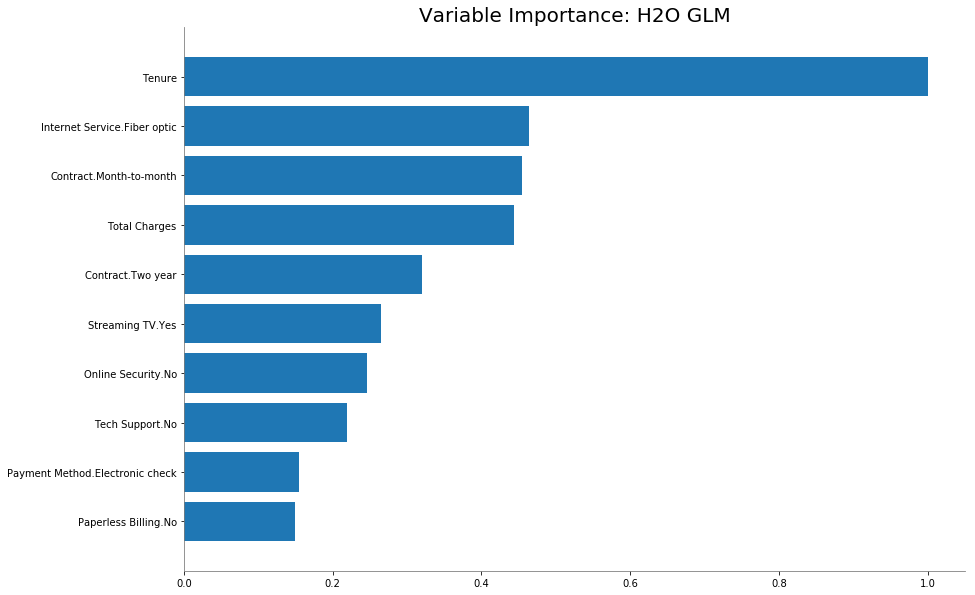

In [127]:
logistic_model_local.varimp_plot()

#### 3.1.2 Partial Dependence Plot

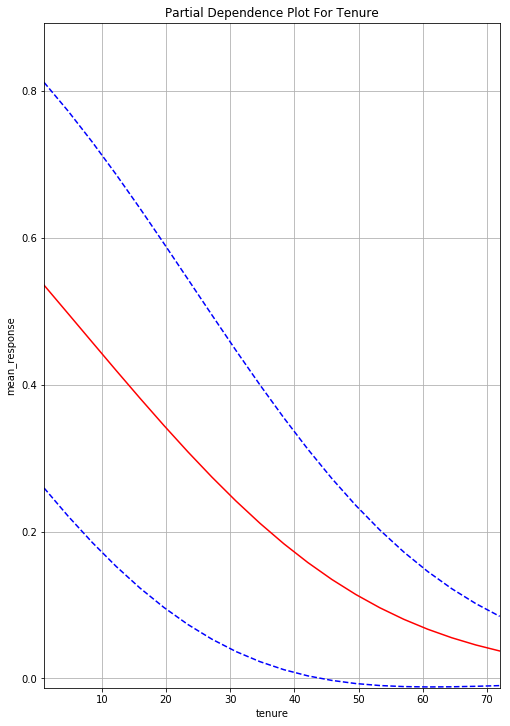

In [142]:
Tenure_PDP = logistic_model_local.partial_plot(data=df, cols=['Tenure'], plot=True, plot_stddev=True)

PartialDependence: Partial Dependence Plot of model GLM_model_python_1597013319592_17144 on column 'Total Charges'



total_charges    mean_response    stddev_response    std_error_mean_response
---------------  ---------------  -----------------  -------------------------
18.8             0.213707         0.240165           0.00386359
474.905          0.228491         0.250588           0.00403127
931.011          0.24367          0.260666           0.00419339
1387.12          0.259209         0.27035            0.00434918
1843.22          0.275071         0.279597           0.00449795
2299.33          0.291218         0.28837            0.00463907
2755.43          0.307614         0.296634           0.00477202
3211.54          0.324222         0.304361           0.00489633
3667.64          0.341007         0.311527           0.00501161
4123.75          0.357934         0.318112           0.00511754
4579.85          0.374971         0.324098           0.00521384
5035.96          0.392085         0.329473           0.0053003
5492.06          0.409247         0.334225           0.00537675
5948.17          0.42643          0.338346           0.00544305
6404.27          0.443607         0.341832           0.00549912
6860.38          0.460754         0.344678           0.00554492
7316.48          0.477849         0.346884           0.00558041
7772.59          0.494871         0.348451           0.00560561
8228.69          0.511801         0.349381           0.00562058
8684.8           0.528622         0.349679           0.00562537

[]

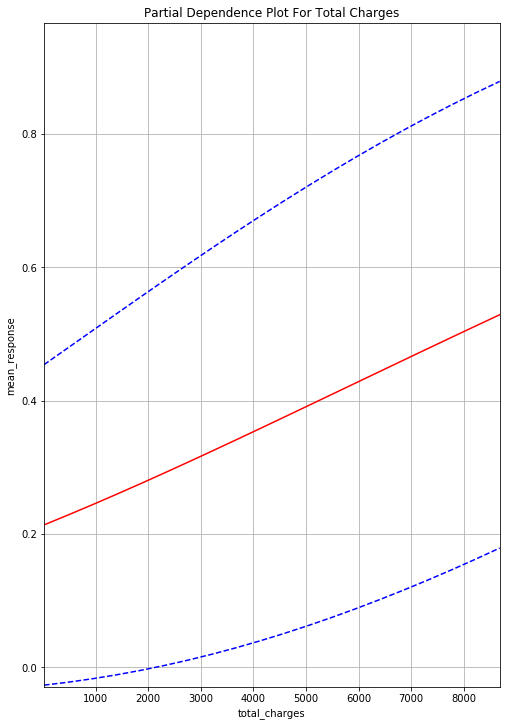

In [129]:
logistic_model_local.partial_plot(data=train, cols=['Total Charges'], plot=True, plot_stddev=True)

In [132]:
# manually calculate 2-D partial dependence

def par_dep_2d(xs1, xs2, frame, model, resolution=20):
    
    """ Creates Pandas dataframe containing partial dependence for two variables.
    
    Args:
        xs1: First variable for which to calculate partial dependence.
        xs2: Second variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs1, xs2, 'partial_dependence'])
    
    # cache original data 
    col_cache1 = frame[xs1]
    col_cache2 = frame[xs2] 
    
    # determine values at which to calculate partial dependency
    # for xs1
    min1_ = frame[xs1].min()
    max1_ = frame[xs1].max()
    by1 = float((max1_ - min1_)/resolution)
    print("min1:" + str(min1_))
    print("max1_" + str(max1_))
    print("by1" + str(by1))
    range1 = np.arange(min1_, max1_, by1)
    
    # determine values at which to calculate partial dependency
    # for xs2
    min2_ = frame[xs2].min()
    max2_ = frame[xs2].max()
    by2 = float((max2_ - min2_)/resolution)
    print("min2:" + str(min2_))
    print("max2_" + str(max2_))
    print("by2" + str(by2))
    range2 = np.arange(min2_, max2_, by2)  
    
    # calculate partial dependency 
    for j in range1:
        for k in range2:
            frame[xs1] = j
            frame[xs2] = k
            par_dep_i = model.predict(frame)
            par_dep_j = par_dep_i.mean()[0]
            std_j = model.predict(frame).sd()[0]
            pos_std, neg_std = par_dep_j + std_j, par_dep_j - std_j
            par_dep_frame = par_dep_frame.append({xs1:j,
                                                  xs2:k,
                                                  'partial_dependence': par_dep_j}, 
                                                  ignore_index=True)

    # return input frame to original cached state    
    frame[xs1] = col_cache1
    frame[xs2] = col_cache2

    return par_dep_frame


In [134]:
# calculate 2-D partial dependence
h2o.no_progress()
resolution = 20
par_dep_Tenure_v_TotalCharges = par_dep_2d('Tenure',
                                           'Total Charges',
                                           df,
                                           logistic_model_local,
                                           resolution=resolution)

print(par_dep_Tenure_v_TotalCharges)

min1:1.0
max1_72.0
by13.55
min2:18.8
max2_8684.8
by2433.3
     Tenure  Total Charges  partial_dependence
0      1.00           18.8            0.501233
1      1.00          452.1            0.528659
2      1.00          885.4            0.557627
3      1.00         1318.7            0.592142
4      1.00         1752.0            0.618952
5      1.00         2185.3            0.649615
6      1.00         2618.6            0.675347
7      1.00         3051.9            0.700000
8      1.00         3485.2            0.722804
9      1.00         3918.5            0.769492
10     1.00         4351.8            0.798613
11     1.00         4785.1            0.824037
12     1.00         5218.4            0.841757
13     1.00         5651.7            0.865177
14     1.00         6085.0            0.893837
15     1.00         6518.3            0.921880
16     1.00         6951.6            0.940524
17     1.00         7384.9            0.955778
18     1.00         7818.2            0.976579
19

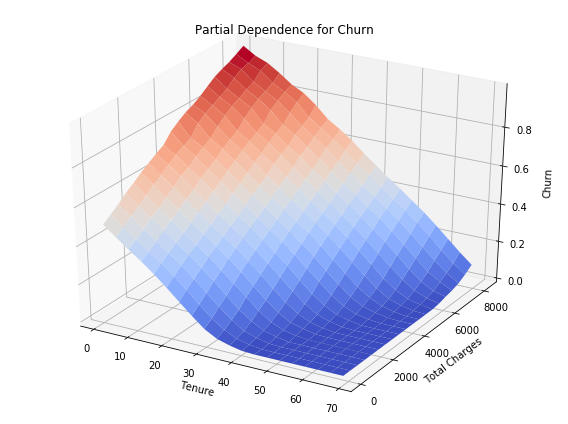

In [137]:
# create 2-D partial dependence plot

# imports
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# create 3-D grid 
new_shape = (resolution, resolution)
x = np.asarray(par_dep_Tenure_v_TotalCharges['Tenure']).reshape(new_shape)
y = np.asarray(par_dep_Tenure_v_TotalCharges['Total Charges']).reshape(new_shape)
z = np.asarray(par_dep_Tenure_v_TotalCharges['partial_dependence']).reshape(new_shape)


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

# set axes labels
ax.set_title('Partial Dependence for Churn')
ax.set_xlabel('Tenure')
ax.set_ylabel('Total Charges')
ax.set_zlabel('\nChurn')

# axis decorators/details
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# surface
surf = ax.plot_surface(x, y, z, 
                       cmap=cm.coolwarm, 
                       linewidth=0.05, 
                       rstride=1, 
                       cstride=1, 
                       antialiased=True)
plt.tight_layout()

_ = plt.show()


#### 3.1.3 Individual Conditional Expectation

In [203]:
# manually calculate 1-D partial dependence
# for educational purposes

def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

# show some output
par_dep_Tenure = par_dep('Tenure', df, logistic_model_local)
# par_dep_Tenure.plot.line(x='Tenure', y='partial_dependence')
# print(par_dep_Tenure)

In [181]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

quantile_dict = get_quantile_dict('Churn', 'Id', df)

In [183]:
bins = list(par_dep_Tenure['Tenure'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_Tenure[col_name] = par_dep('Tenure',
                                   df[df['Id'] == int(quantile_dict[i])],
                                   logistic_model_local,
                                   bins=bins)['partial_dependence']
par_dep_Tenure

Tenure  partial_dependence  Percentile_0  Percentile_10  Percentile_20  \
0     1.00            0.655008           1.0            1.0            0.0   
1     4.55            0.608783           1.0            1.0            0.0   
2     8.10            0.559630           1.0            1.0            0.0   
3    11.65            0.513713           1.0            0.0            0.0   
4    15.20            0.469954           1.0            0.0            0.0   
5    18.75            0.426502           0.0            0.0            0.0   
6    22.30            0.378582           0.0            0.0            0.0   
7    25.85            0.320493           0.0            0.0            0.0   
8    29.40            0.269337           0.0            0.0            0.0   
9    32.95            0.212481           0.0            0.0            0.0   
10   36.50            0.158243           0.0            0.0            0.0   
11   40.05            0.115100           0.0            0.0            0.0   
12   43.60            0.082589           0.0            0.0            0.0   
13   47.15            0.054083           0.0            0.0            0.0   
14   50.70            0.033436           0.0            0.0            0.0   
15   54.25            0.021109           0.0            0.0            0.0   
16   57.80            0.011864           0.0            0.0            0.0   
17   61.35            0.005393           0.0            0.0            0.0   
18   64.90            0.002311           0.0            0.0            0.0   
19   68.45            0.000616           0.0            0.0            0.0   

    Percentile_30  Percentile_40  Percentile_50  Percentile_60  Percentile_70  \
0             1.0            0.0            0.0            1.0            0.0   
1             1.0            0.0            0.0            0.0            0.0   
2             1.0            0.0            0.0            0.0            0.0   
3             1.0            0.0            0.0            0.0            0.0   
4             1.0            0.0            0.0            0.0            0.0   
5             1.0            0.0            0.0            0.0            0.0   
6             1.0            0.0            0.0            0.0            0.0   
7             1.0            0.0            0.0            0.0            0.0   
8             1.0            0.0            0.0            0.0            0.0   
9             0.0            0.0            0.0            0.0            0.0   
10            0.0            0.0            0.0            0.0            0.0   
11            0.0            0.0            0.0            0.0            0.0   
12            0.0            0.0            0.0            0.0            0.0   
13            0.0            0.0            0.0            0.0            0.0   
14            0.0            0.0            0.0            0.0            0.0   
15            0.0            0.0            0.0            0.0            0.0   
16            0.0            0.0            0.0            0.0            0.0   
17            0.0            0.0            0.0            0.0            0.0   
18            0.0            0.0            0.0            0.0            0.0   
19            0.0            0.0            0.0            0.0            0.0   

    Percentile_80  Percentile_90  Percentile_99  
0             1.0            1.0            1.0  
1             1.0            0.0            1.0  
2             1.0            0.0            1.0  
3             1.0            0.0            1.0  
4             1.0            0.0            1.0  
5             1.0            0.0            1.0  
6             0.0            0.0            0.0  
7             0.0            0.0            0.0  
8             0.0            0.0            0.0  
9             0.0            0.0            0.0  
10            0.0            0.0            0.0  
11            0.0            0.0            0.0  
12           

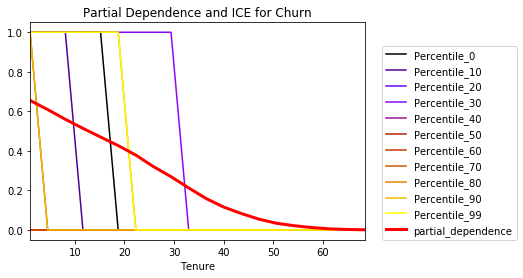

In [184]:
fig, ax = plt.subplots()
par_dep_Tenure.drop('partial_dependence', axis=1).plot(x='Tenure', colormap='gnuplot', ax=ax)

par_dep_Tenure.plot(title='Partial Dependence and ICE for Churn',
                         x='Tenure', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## 3.2 Gradient Boosting Machine

In [185]:
# Training BGM model

gbm_model_local.train(x=X, y=target, training_frame=train, validation_frame = valid)

In [186]:
# The Performance of BGM model

gbm_model_local.model_performance()


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10317340756401237
RMSE: 0.32120617609879853
LogLoss: 0.3305658187390948
Mean Per-Class Error: 0.15369427869427865
AUC: 0.9176863520492865
pr_auc: 0.8046855934562773
Gini: 0.835372704098573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3760811955332678: 


No    Yes    Error    Rate
-----  ----  -----  -------  --------------
No     2495  354    0.1243   (354.0/2849.0)
Yes    214   822    0.2066   (214.0/1036.0)
Total  2709  1176   0.1462   (568.0/3885.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376081     0.743219  201
max f2                       0.25992      0.822818  249
max f0point5                 0.535847     0.738465  137
max accuracy                 0.422692     0.855084  183
max precision                0.928888     1         0
max recall                   0.0296397    1         382
max specificity              0.928888     1         0
max absolute_mcc             0.376081     0.644113  201
max min_per_class_accuracy   0.33003      0.837838  220
max mean_per_class_accuracy  0.281874     0.846306  240

Gains/Lift Table: Avg response rate: 26.67 %, avg score: 26.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100386                   0.88993            3.75       3.75               1                0.906572   1                           0.906572            0.0376448       0.0376448                  275       275
    2        0.0200772                   0.857918           3.55769    3.65385            0.948718         0.877831   0.974359                    0.892202            0.0357143       0.0733591                  255.769   265.385
    3        0.0301158                   0.836608           3.65385    3.65385            0.974359         0.847817   0.974359                    0.877407            0.0366795       0.110039                   265.385   265.385
    4        0.0404118                   0.816995           3.28125    3.55892            0.875            0.826892   0.949045                    0.864537            0.0337838       0.143822                   228.125   255.892
    5        0.0501931                   0.790143           3.35526    3.51923            0.894737         0.803688   0.938462                    0.852679            0.0328185       0.176641                   235.526   251.923
    6        0.100129                    0.683809           3.38273    3.45116            0.902062         0.73677    0.920308                    0.794874            0.168919        0.34556                    238.273   245.116
    7        0.150064                    0.591725           2.53222    3.14537            0.675258         0.638648   0.838765                    0.742888            0.126448        0.472008                   153.222   214.537
    8        0.2                         0.522964           2.30026    2.93436            0.613402         0.556599   0.782497                    0.696375            0.114865        0.586873                   130.026   193.436
    9        0.300129                    0.378485           2.00514    2.62436            0.534704         0.451018   0.699828                    0.614519            0.200772        0.787645                   100.514   162.436
    10       0.4                         0.261637           1.15013    2.25627            0.306701         0.318125   0.601673                    0.540516            0.114865        0.90251                    15.0129   125.627
    11       0.500386                    0.164959           0.5        1.90394            0.133333         0.212573   0.507716                    0.474725            0.0501931       0.952703                   -50       90.3935
    12       0.6                         0.0988879          0.242248   1.62806            0.0645995        0.131579   0.434148                    0.417755            0.0241313       0.976834                   -75.7752  62.8057
    13       0.699871                    0.0552501          0.144974   1.41642            0.0386598        0.074176   0.377712                    0.368726            0.0144788       0.991313                   -85.5026  41.6421
    14       0.8                         0.0339601          0.0674807  1.24759            0.0179949        0.0430926  0.33269                     0.32797             0.00675676      0.998069                   -93.2519  24.7587
    15       0.899871                    0.021278           0.0193299  1.11127            0.00515464       0.0276263  0.296339                    0.294636            0.0019305       1                          -98.067   11.127
    16       1                           0.0109891          0          1                  0                0.0176606  0.266667      

#### 3.2.1 Variable Importance

Different from the Variable Importance Plot we generated from the Logistic Regression Model, the most important variable in Gradient Boosting Model is 'Contract'. That could be a reason of changing the model to a tree-based model, and the Contract column can be seen as a very important Leaf Node.

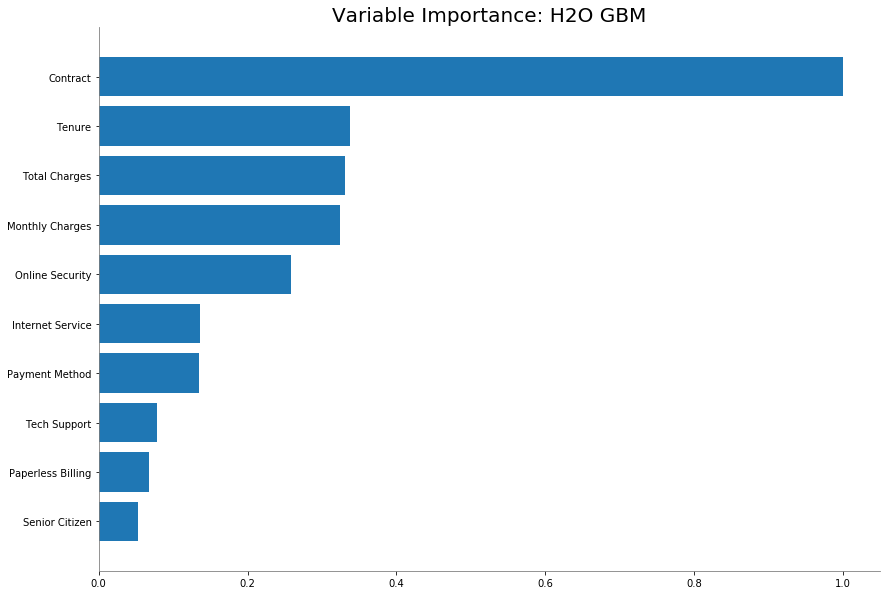

In [187]:
gbm_model_local.varimp_plot()

#### 3.2.2 Partial Dependence Plot

PartialDependence: Partial Dependence Plot of model GBM_model_python_1597013319592_18792 on column 'Tenure'



tenure    mean_response    stddev_response    std_error_mean_response
--------  ---------------  -----------------  -------------------------
1         0.403422         0.290896           0.00466704
4.73684   0.332518         0.252781           0.00405555
8.47368   0.324502         0.247122           0.00396475
12.2105   0.292124         0.230649           0.00370046
15.9474   0.270625         0.222318           0.0035668
19.6842   0.260598         0.222969           0.00357724
23.4211   0.213058         0.188644           0.00302655
27.1579   0.215799         0.193432           0.00310337
30.8947   0.214521         0.192816           0.00309348
34.6316   0.214521         0.192816           0.00309348
38.3684   0.210537         0.189039           0.00303289
42.1053   0.205425         0.183368           0.00294189
45.8421   0.201988         0.182094           0.00292146
49.5789   0.20378          0.186845           0.00299768
53.3158   0.202154         0.173915           0.00279024
57.0526   0.178287         0.158294           0.00253961
60.7895   0.148226         0.13296            0.00213316
64.5263   0.151791         0.13629            0.00218659
68.2632   0.151798         0.136288           0.00218656
72        0.119181         0.109094           0.00175027

[]

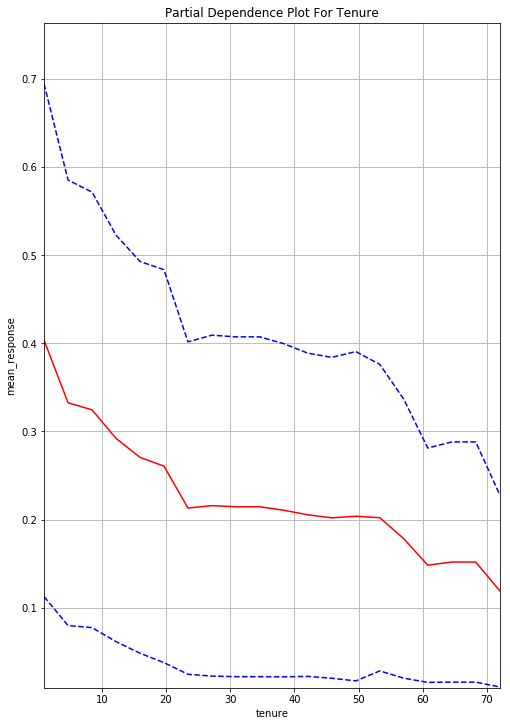

In [188]:
gbm_model_local.partial_plot(data=train, cols=['Tenure'], plot=True, plot_stddev=True)

PartialDependence: Partial Dependence Plot of model GBM_model_python_1597013319592_18792 on column 'Total Charges'



total_charges    mean_response    stddev_response    std_error_mean_response
---------------  ---------------  -----------------  -------------------------
18.8             0.29997          0.277413           0.00445072
467.661          0.259364         0.250008           0.00401106
916.521          0.275654         0.229868           0.00368793
1365.38          0.267032         0.232126           0.00372416
1814.24          0.268349         0.237749           0.00381437
2263.1           0.277195         0.240535           0.00385907
2711.96          0.278382         0.241274           0.00387092
3160.82          0.253176         0.222741           0.00357359
3609.68          0.242223         0.213556           0.00342623
4058.54          0.250884         0.220595           0.00353916
4507.41          0.26716          0.235947           0.00378547
4956.27          0.246825         0.217148           0.00348386
5405.13          0.271242         0.235066           0.00377133
5853.99          0.26278          0.23488            0.00376834
6302.85          0.270191         0.228881           0.0036721
6751.71          0.259121         0.228884           0.00367215
7200.57          0.272957         0.238515           0.00382666
7649.43          0.315727         0.246238           0.00395057
8098.29          0.31422          0.246574           0.00395596
8547.15          0.31422          0.246574           0.00395596

[]

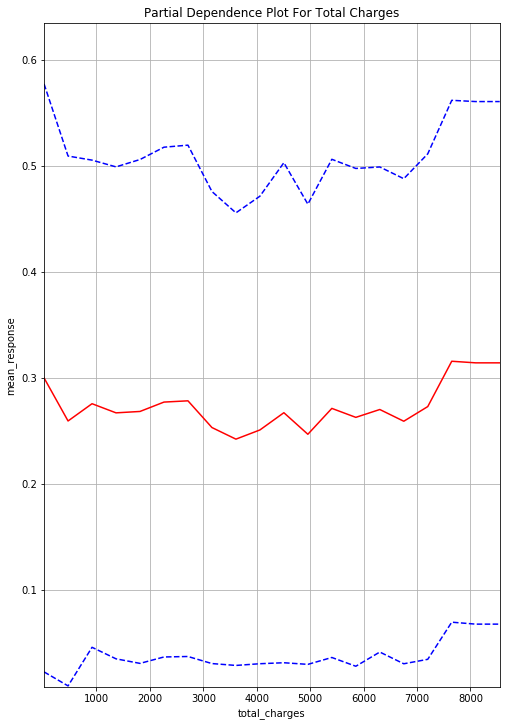

In [207]:
gbm_model_local.partial_plot(data=train, cols=['Total Charges'], plot=True, plot_stddev=True)

In [204]:
# calculate 2-D partial dependence
h2o.no_progress()
resolution = 20
par_dep_Tenure_v_TotalCharges_GBM = par_dep_2d('Tenure',
                                           'Total Charges',
                                           df,
                                           gbm_model_local,
                                           resolution=resolution)

print(par_dep_Tenure_v_TotalCharges_GBM)

min1:1.0
max1_72.0
by13.55
min2:18.8
max2_8684.8
by2433.3
     Tenure  Total Charges  partial_dependence
0      1.00           18.8            0.551926
1      1.00          452.1            0.528659
2      1.00          885.4            0.624499
3      1.00         1318.7            0.622958
4      1.00         1752.0            0.635285
5      1.00         2185.3            0.627735
6      1.00         2618.6            0.631433
7      1.00         3051.9            0.630508
8      1.00         3485.2            0.620339
9      1.00         3918.5            0.605701
10     1.00         4351.8            0.618336
11     1.00         4785.1            0.626656
12     1.00         5218.4            0.642373
13     1.00         5651.7            0.620647
14     1.00         6085.0            0.643914
15     1.00         6518.3            0.621109
16     1.00         6951.6            0.636980
17     1.00         7384.9            0.640062
18     1.00         7818.2            0.683513
19

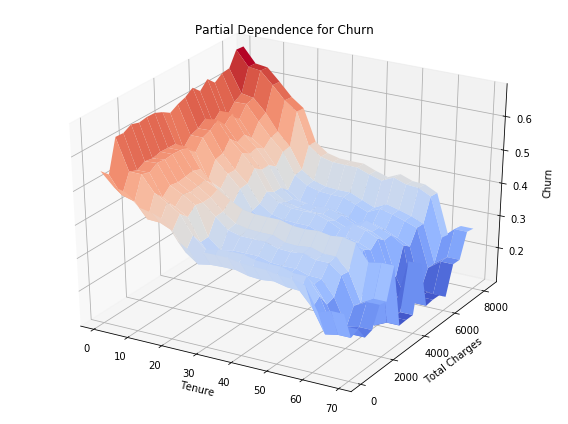

In [205]:
# create 3-D grid 
new_shape = (resolution, resolution)
x = np.asarray(par_dep_Tenure_v_TotalCharges_GBM['Tenure']).reshape(new_shape)
y = np.asarray(par_dep_Tenure_v_TotalCharges_GBM['Total Charges']).reshape(new_shape)
z = np.asarray(par_dep_Tenure_v_TotalCharges_GBM['partial_dependence']).reshape(new_shape)


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

# set axes labels
ax.set_title('Partial Dependence for Churn')
ax.set_xlabel('Tenure')
ax.set_ylabel('Total Charges')
ax.set_zlabel('\nChurn')

# axis decorators/details
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# surface
surf = ax.plot_surface(x, y, z, 
                       cmap=cm.coolwarm, 
                       linewidth=0.05, 
                       rstride=1, 
                       cstride=1, 
                       antialiased=True)
plt.tight_layout()

_ = plt.show()


#### 3.2.3 Individual Conditional Expectation

In [206]:
gbm_par_dep_Tenure = par_dep('Tenure', df, gbm_model_local)
# gbm_par_dep_Tenure.plot.line(x='Tenure', y='partial_dependence')
# print(gbm_par_dep_Tenure)

In [190]:
quantile_dict = get_quantile_dict('Churn', 'Id', df)

In [200]:
bins = list(gbm_par_dep_Tenure['Tenure'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    gbm_par_dep_Tenure[col_name] = par_dep('Tenure',
                                   df[df['Id'] == int(quantile_dict[i])],
                                   gbm_model_local,
                                   bins=bins)['partial_dependence']
gbm_par_dep_Tenure

Tenure  partial_dependence  Percentile_0  Percentile_10  Percentile_20  \
0     1.00            0.576888           1.0            0.0            0.0   
1     4.55            0.507550           1.0            0.0            0.0   
2     8.10            0.500000           1.0            0.0            0.0   
3    11.65            0.456086           1.0            0.0            0.0   
4    15.20            0.443143           1.0            0.0            0.0   
5    18.75            0.420339           1.0            0.0            0.0   
6    22.30            0.359322           1.0            0.0            0.0   
7    25.85            0.330354           1.0            0.0            0.0   
8    29.40            0.337442           1.0            0.0            0.0   
9    32.95            0.336826           1.0            0.0            0.0   
10   36.50            0.336826           1.0            0.0            0.0   
11   40.05            0.322804           1.0            0.0            0.0   
12   43.60            0.312481           1.0            0.0            0.0   
13   47.15            0.318952           1.0            0.0            0.0   
14   50.70            0.310015           1.0            0.0            0.0   
15   54.25            0.306163           1.0            0.0            0.0   
16   57.80            0.273960           1.0            0.0            0.0   
17   61.35            0.192758           1.0            0.0            0.0   
18   64.90            0.205239           1.0            0.0            0.0   
19   68.45            0.205239           1.0            0.0            0.0   

    Percentile_30  Percentile_40  Percentile_50  Percentile_60  Percentile_70  \
0             1.0            1.0            0.0            1.0            0.0   
1             1.0            1.0            0.0            0.0            0.0   
2             1.0            1.0            0.0            0.0            0.0   
3             1.0            1.0            0.0            0.0            0.0   
4             1.0            1.0            0.0            0.0            0.0   
5             1.0            1.0            0.0            0.0            0.0   
6             1.0            0.0            0.0            0.0            0.0   
7             1.0            0.0            0.0            0.0            0.0   
8             1.0            0.0            0.0            0.0            0.0   
9             1.0            0.0            0.0            0.0            0.0   
10            1.0            0.0            0.0            0.0            0.0   
11            1.0            0.0            0.0            0.0            0.0   
12            1.0            0.0            0.0            0.0            0.0   
13            1.0            0.0            0.0            0.0            0.0   
14            1.0            0.0            0.0            0.0            0.0   
15            1.0            0.0            0.0            0.0            0.0   
16            1.0            0.0            0.0            0.0            0.0   
17            1.0            0.0            0.0            0.0            0.0   
18            1.0            0.0            0.0            0.0            0.0   
19            1.0            0.0            0.0            0.0            0.0   

    Percentile_80  Percentile_90  Percentile_99  
0             1.0            1.0            1.0  
1             1.0            1.0            1.0  
2             1.0            1.0            1.0  
3             1.0            0.0            1.0  
4             1.0            0.0            1.0  
5             1.0            0.0            1.0  
6             1.0            0.0            1.0  
7             1.0            0.0            1.0  
8             1.0            0.0            1.0  
9             1.0            0.0            1.0  
10            1.0            0.0            1.0  
11            1.0            0.0            1.0  
12           

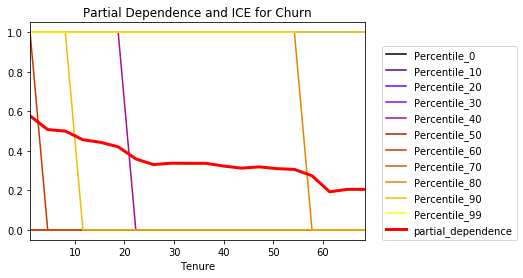

In [201]:
fig, ax = plt.subplots()
gbm_par_dep_Tenure.drop('partial_dependence', axis=1).plot(x='Tenure', colormap='gnuplot', ax=ax)

gbm_par_dep_Tenure.plot(title='Partial Dependence and ICE for Churn',
                         x='Tenure', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## 3.3 XGBoost

In [193]:
# Trainig the XGBoost Model and the Performance of the model

xgboost_model_local.train(x=X, y=target, training_frame=train, validation_frame = valid)
xgboost_model_local.model_performance()


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06132453573019107
RMSE: 0.2476379125461024
LogLoss: 0.21775439530372342
Mean Per-Class Error: 0.06897156897156898
AUC: 0.979129370056011
pr_auc: 0.9411672125904095
Gini: 0.958258740112022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4160831719636917: 


No    Yes    Error    Rate
-----  ----  -----  -------  --------------
No     2682  167    0.0586   (167.0/2849.0)
Yes    91    945    0.0878   (91.0/1036.0)
Total  2773  1112   0.0664   (258.0/3885.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416083     0.879888  197
max f2                       0.300341     0.916879  234
max f0point5                 0.538773     0.894264  151
max accuracy                 0.426468     0.934106  193
max precision                0.977629     1         0
max recall                   0.0642277    1         342
max specificity              0.977629     1         0
max absolute_mcc             0.416083     0.835075  197
max min_per_class_accuracy   0.387992     0.928571  206
max mean_per_class_accuracy  0.358554     0.931028  215

Gains/Lift Table: Avg response rate: 26.67 %, avg score: 26.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100386                   0.942419           3.75       3.75               1                0.955246    1                           0.955246            0.0376448       0.0376448                  275       275
    2        0.0200772                   0.92123            3.65385    3.70192            0.974359         0.93164     0.987179                    0.943443            0.0366795       0.0743243                  265.385   270.192
    3        0.0301158                   0.905054           3.75       3.71795            1                0.912467    0.991453                    0.933118            0.0376448       0.111969                   275       271.795
    4        0.0401544                   0.886043           3.75       3.72596            1                0.895639    0.99359                     0.923748            0.0376448       0.149614                   275       272.596
    5        0.0501931                   0.864854           3.75       3.73077            1                0.876365    0.994872                    0.914271            0.0376448       0.187259                   275       273.077
    6        0.100129                    0.781432           3.59536    3.66324            0.958763         0.822893    0.976864                    0.8687              0.179537        0.366795                   259.536   266.324
    7        0.150064                    0.692532           3.51804    3.61492            0.938144         0.736142    0.963979                    0.824589            0.175676        0.542471                   251.804   261.492
    8        0.2                         0.595932           3.32474    3.54247            0.886598         0.641009    0.944659                    0.778753            0.166023        0.708494                   232.474   254.247
    9        0.300129                    0.384405           2.21722    3.10034            0.59126          0.488923    0.826758                    0.68206             0.222008        0.930502                   121.722   210.034
    10       0.4                         0.21663            0.560567   2.46622            0.149485         0.295491    0.657658                    0.585542            0.0559846       0.986486                   -43.9433  146.622
    11       0.500129                    0.120662           0.0867609  1.98984            0.0231362        0.163212    0.530623                    0.500989            0.00868726      0.995174                   -91.3239  98.9835
    12       0.6                         0.060918           0.0483247  1.66667            0.0128866        0.0882648   0.444444                    0.43229             0.00482625      1                          -95.1675  66.6667
    13       0.699871                    0.030785           0          1.42883            0                0.0440276   0.381022                    0.376885            0               1                          -100      42.8834
    14       0.8                         0.0131013          0          1.25               0                0.0209528   0.333333                    0.332337            0               1                          -100      25
    15       0.899871                    0.00490386         0          1.11127            0                0.00840766  0.296339                    0.296386            0               1                          -100      11.127
    16       1                           0.000341115        0          1                  0                0.00246676  0

#### 3.3.1 Variable Importance

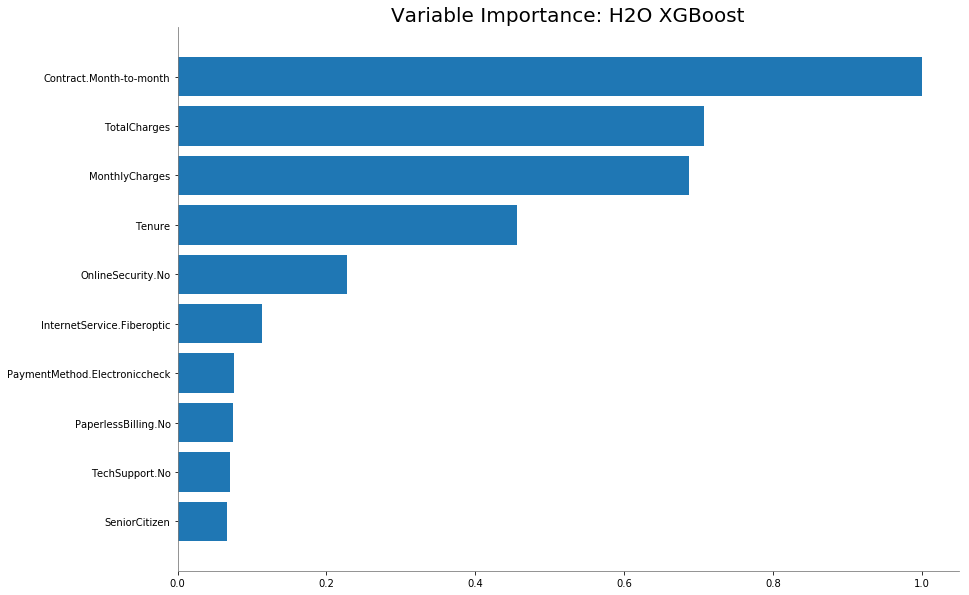

In [194]:
xgboost_model_local.varimp_plot()

#### 3.3.2 Partial Dependence Plot

PartialDependence: Partial Dependence Plot of model XGBoost_model_python_1597013319592_19135 on column 'Tenure'



tenure    mean_response    stddev_response    std_error_mean_response
--------  ---------------  -----------------  -------------------------
1         0.339072         0.317581           0.00394214
4.73684   0.326568         0.309221           0.00383837
8.47368   0.31895          0.302535           0.00375538
12.2105   0.273232         0.26272            0.00326115
15.9474   0.254135         0.254503           0.00315916
19.6842   0.268944         0.260925           0.00323887
23.4211   0.204109         0.211405           0.00262417
27.1579   0.212003         0.232653           0.00288793
30.8947   0.20895          0.229404           0.0028476
34.6316   0.20799          0.227274           0.00282115
38.3684   0.214465         0.227362           0.00282226
42.1053   0.205011         0.224477           0.00278644
45.8421   0.199106         0.221042           0.0027438
49.5789   0.204554         0.232444           0.00288534
53.3158   0.222178         0.218624           0.00271378
57.0526   0.140154         0.168352           0.00208976
60.7895   0.111462         0.145668           0.00180818
64.5263   0.102325         0.136904           0.0016994
68.2632   0.125576         0.161596           0.0020059
72        0.0795766        0.118795           0.0014746

[]

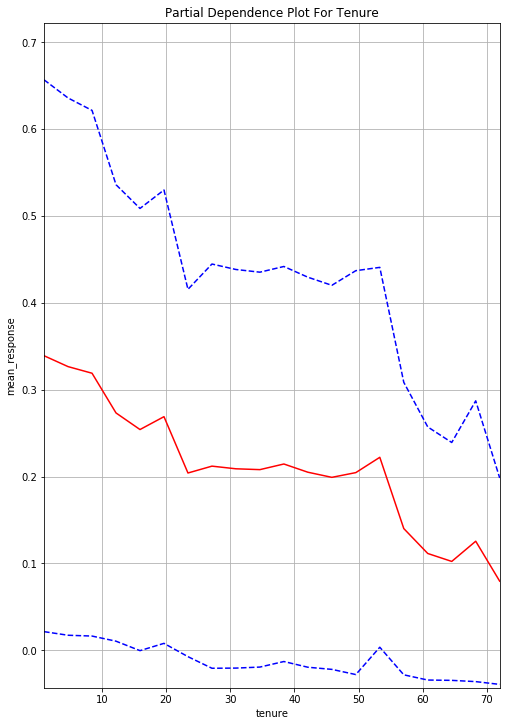

In [211]:
xgboost_model_local.partial_plot(data=df, cols=['Tenure'], plot=True, plot_stddev=True)

PartialDependence: Partial Dependence Plot of model XGBoost_model_python_1597013319592_19135 on column 'Total Charges'



total_charges    mean_response    stddev_response    std_error_mean_response
---------------  ---------------  -----------------  -------------------------
18.8             0.423861         0.326132           0.00404828
474.905          0.246452         0.273815           0.00339888
931.011          0.291677         0.263965           0.0032766
1387.12          0.231646         0.261504           0.00324605
1843.22          0.201725         0.24006            0.00297987
2299.33          0.214793         0.249119           0.00309232
2755.43          0.222558         0.251762           0.00312513
3211.54          0.247906         0.270363           0.00335602
3667.64          0.167894         0.197648           0.00245341
4123.75          0.235004         0.245141           0.00304294
4579.85          0.199801         0.232537           0.00288649
5035.96          0.205319         0.216903           0.00269243
5492.06          0.245962         0.245496           0.00304735
5948.17          0.225787         0.237675           0.00295026
6404.27          0.23489          0.239884           0.00297769
6860.38          0.220249         0.233513           0.0028986
7316.48          0.237557         0.238847           0.00296482
7772.59          0.234131         0.23156            0.00287436
8228.69          0.233609         0.231439           0.00287286
8684.8           0.233609         0.231439           0.00287286

[]

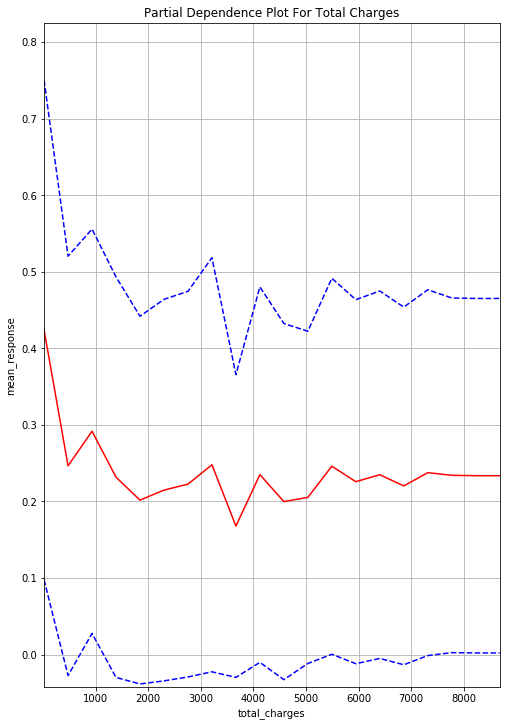

In [196]:
xgboost_model_local.partial_plot(data=df, cols=['Total Charges'], plot=True, plot_stddev=True)

In [209]:
# calculate 2-D partial dependence
h2o.no_progress()
resolution = 20
par_dep_Tenure_v_TotalCharges_XGB = par_dep_2d('Tenure',
                                           'Total Charges',
                                           df,
                                           xgboost_model_local,
                                           resolution=resolution)

print(par_dep_Tenure_v_TotalCharges_XGB)

min1:1.0
max1_72.0
by13.55
min2:18.8
max2_8684.8
by2433.3
     Tenure  Total Charges  partial_dependence
0      1.00           18.8            0.663790
1      1.00          452.1            0.448844
2      1.00          885.4            0.452388
3      1.00         1318.7            0.440986
4      1.00         1752.0            0.448382
5      1.00         2185.3            0.446995
6      1.00         2618.6            0.409245
7      1.00         3051.9            0.461325
8      1.00         3485.2            0.413713
9      1.00         3918.5            0.321572
10     1.00         4351.8            0.547304
11     1.00         4785.1            0.563174
12     1.00         5218.4            0.387827
13     1.00         5651.7            0.385362
14     1.00         6085.0            0.527273
15     1.00         6518.3            0.445609
16     1.00         6951.6            0.467951
17     1.00         7384.9            0.401695
18     1.00         7818.2            0.451002
19

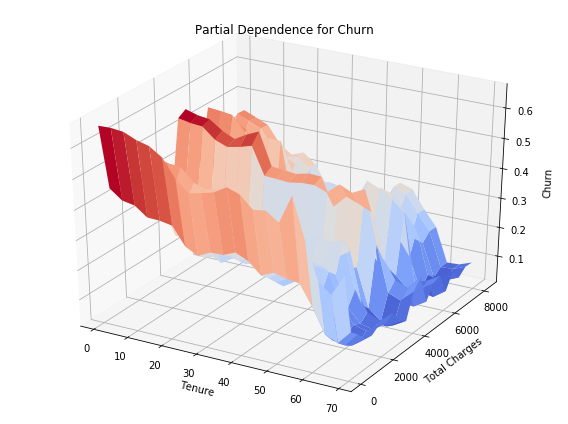

In [210]:
# create 3-D grid 
new_shape = (resolution, resolution)
x = np.asarray(par_dep_Tenure_v_TotalCharges_XGB['Tenure']).reshape(new_shape)
y = np.asarray(par_dep_Tenure_v_TotalCharges_XGB['Total Charges']).reshape(new_shape)
z = np.asarray(par_dep_Tenure_v_TotalCharges_XGB['partial_dependence']).reshape(new_shape)


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

# set axes labels
ax.set_title('Partial Dependence for Churn')
ax.set_xlabel('Tenure')
ax.set_ylabel('Total Charges')
ax.set_zlabel('\nChurn')

# axis decorators/details
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# surface
surf = ax.plot_surface(x, y, z, 
                       cmap=cm.coolwarm, 
                       linewidth=0.05, 
                       rstride=1, 
                       cstride=1, 
                       antialiased=True)
plt.tight_layout()

_ = plt.show()


#### 3.3.3 Individual Conditional Expectation

In [208]:
xgboost_par_dep_TC = par_dep('Total Charges', df, xgboost_model_local)
# xgboost_par_dep_TC.plot.line(x='Total Charges', y='partial_dependence')
# print(xgboost_par_dep_TC)

In [199]:
# quantile_dict = get_quantile_dict('Churn', 'Id', df)

bins = list(xgboost_par_dep_TC['Total Charges'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    xgboost_par_dep_TC[col_name] = par_dep('Total Charges',
                                   df[df['Id'] == int(quantile_dict[i])],
                                   xgboost_model_local,
                                   bins=bins)['partial_dependence']
xgboost_par_dep_TC

Total Charges  partial_dependence  Percentile_0  Percentile_10  \
0            18.8            0.574422           1.0            0.0   
1           452.1            0.333128           1.0            0.0   
2           885.4            0.338829           1.0            0.0   
3          1318.7            0.310015           1.0            0.0   
4          1752.0            0.310786           1.0            0.0   
5          2185.3            0.326965           1.0            0.0   
6          2618.6            0.306626           1.0            0.0   
7          3051.9            0.359168           1.0            0.0   
8          3485.2            0.290755           1.0            0.0   
9          3918.5            0.200462           1.0            0.0   
10         4351.8            0.452080           1.0            0.0   
11         4785.1            0.441757           1.0            0.0   
12         5218.4            0.252388           1.0            0.0   
13         5651.7            0.271495           1.0            0.0   
14         6085.0            0.417720           1.0            0.0   
15         6518.3            0.323267           1.0            0.0   
16         6951.6            0.354854           1.0            0.0   
17         7384.9            0.274268           1.0            0.0   
18         7818.2            0.329584           1.0            0.0   
19         8251.5            0.328351           1.0            0.0   

    Percentile_20  Percentile_30  Percentile_40  Percentile_50  Percentile_60  \
0             0.0            1.0            1.0            1.0            1.0   
1             0.0            1.0            0.0            0.0            0.0   
2             0.0            1.0            0.0            0.0            0.0   
3             0.0            1.0            0.0            0.0            0.0   
4             0.0            1.0            0.0            0.0            0.0   
5             0.0            1.0            0.0            0.0            0.0   
6             0.0            1.0            0.0            0.0            0.0   
7             0.0            1.0            0.0            0.0            0.0   
8             0.0            1.0            0.0            0.0            0.0   
9             0.0            0.0            0.0            0.0            0.0   
10            0.0            1.0            1.0            0.0            0.0   
11            0.0            1.0            1.0            0.0            0.0   
12            0.0            0.0            1.0            0.0            0.0   
13            0.0            1.0            1.0            0.0            0.0   
14            0.0            1.0            1.0            0.0            0.0   
15            0.0            1.0            1.0            0.0            0.0   
16            0.0            1.0            1.0            0.0            0.0   
17            0.0            1.0            1.0            0.0            0.0   
18            0.0            1.0            1.0            0.0            0.0   
19            0.0            1.0            1.0            0.0            0.0   

    Percentile_70  Percentile_80  Percentile_90  Percentile_99  
0             0.0            1.0            1.0            1.0  
1             0.0            1.0            1.0            1.0  
2             0.0            1.0            1.0            1.0  
3             0.0            1.0            1.0            1.0  
4             0.0            1.0            1.0            1.0  
5             0.0            1.0            1.0            1.0  
6             0.0            1.0            1.0            1.0  
7             0.0            1.0            1.0            1.0  
8             0.0            1.0            1.0            1.0  
9             0.0            0.0            0.0            1.0  
10            0.0            1.0            1.0            1.0  
11            0.0            1.0            1.0    

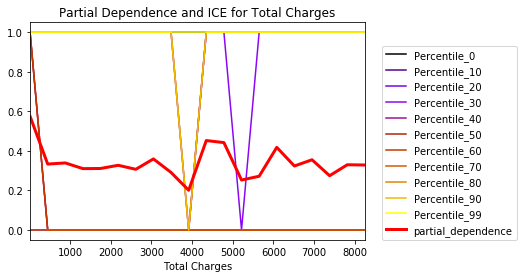

In [202]:
fig, ax = plt.subplots()
xgboost_par_dep_TC.drop('partial_dependence', axis=1).plot(x='Total Charges', colormap='gnuplot', ax=ax)

xgboost_par_dep_TC.plot(title='Partial Dependence and ICE for Total Charges',
                         x='Total Charges', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)